In [151]:
# youtube_blog_generator.py
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from youtube_transcript_api import YouTubeTranscriptApi
import streamlit as st
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

# Load environment variables
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Initialize LLM
llm = ChatGroq(model="qwen-2.5-32b")

# Graph State
class State(TypedDict):
    java_code: str
    python_code: str
    reviewer_feedback: str
    human_feedback: str
    decision: str
    reviewed_python_code: str
    human_reviewed_python_code: str
    

In [152]:
def python_code_converter(state: State):
        """Convert the java code received in the input to a python code"""
        print("Inside python code converter when reviewer feedback is NOT present")
        msg = llm.invoke(f"You are a python code expert. Pls covert the provided java code as input to python code. {state['java_code']}")
        return ({"python_code": msg.content, "decision": "Not Reqd"})
        

In [153]:
def review_python_code(state:State):
    if state["decision"] == "Review Reqd":
        """Review the python code and remove extra comments"""
        print("Inside review_python_code when reviewer feedback is present")
        msg = llm.invoke(f"""You are a python code reviewer. Pls remove the additional comments,python documentation from the python code. It should be only python code. No preamble in the code {state["python_code"]}
            No Starting line such as `Here is the revised Python code with no comments or documentation`. No Python keyword prefixed. Please consider the reviwer feedback {state["reviewer_feedback"]} on the generated python code. Please take care of python code formatting""")
        print("Reviewed python code is ::", msg)
        return ({"reviewed_python_code": msg.content})

In [154]:
def reviewer(state: State):
        """Check if the python code generated has any preamble"""
        python_code = state["python_code"]
        to_remove_str ="Python code"
        print("Inside Reviwer")
        if to_remove_str in (python_code):
            print("Reviewer feedback required")
            return({"reviewer_feedback": "Check if the python code generated has additional commentary or python documentation or any preamble. If yes, pls remove it.","decision": "Review Reqd","human_feedback":"Required"})
        else:
            return({"reviewer_feedback": "Not Required" , "decision": "Not Reqd", "human_feedback":"Not Required"})
       
def feedback_approval(state: State):
        """Route to human feedback if accepted else end if rejected"""

        if state["reviewer_feedback"] != "Not Required":
            print("Review Accepted for change")
            return "Need Change"
        elif state["reviewer_feedback"] == "Not Required":
            print("Review not required. END it")
            return "No Further Review"

In [155]:
def take_human_feedback(state:State):
    print("Human Feedback is ", state["human_feedback"])

def human_feedback_approval(state:State):
    """ Return the next node to execute """
    print("Human Feedback conditional edge called")
    # Check if human feedback
    if state["human_feedback"] == "Required":
            print("Human Feedback approval accepted")
            return "Required"
    else:
            return "Not Required"

In [156]:
def gen_final_code(state:State):
    if state["human_feedback"] == "Required":
        """Review the python code and remove extra comments and new lines"""
        print("Inside reviegen_final_codew_python_code when human feedback is required")
        msg = llm.invoke(f"""You are a python code reviewer. Pls remove the additional comments,python documentation from the python code if any found. Remove extra lines and new line tags. It should be only python code. No preamble in the code {state["reviewed_python_code"]}
            No Starting line such as `Here is the revised Python code with no comments or documentation`. No Python keyword prefixed. """)
        print("Reviewed human python code is ::", msg)
        return ({"human_reviewed_python_code": msg.content})

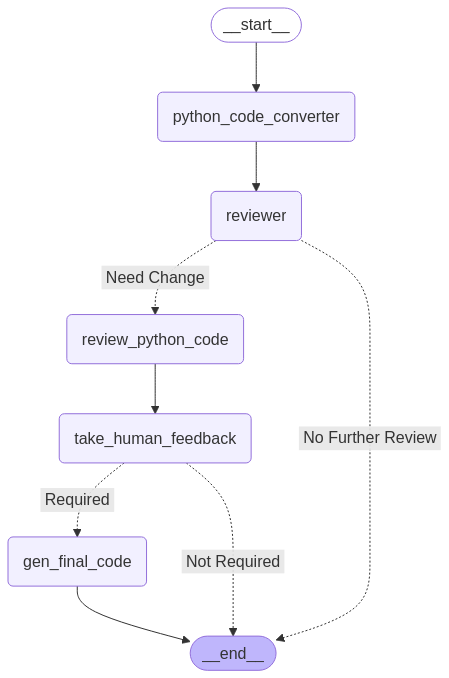

In [158]:
# Build and compile the workflow
workflow1 = StateGraph(State)
    
# Add nodes
workflow1.add_node("python_code_converter", python_code_converter)
workflow1.add_node("reviewer", reviewer)
workflow1.add_node("review_python_code",review_python_code)
workflow1.add_node("take_human_feedback", take_human_feedback)
workflow1.add_node("gen_final_code", gen_final_code)
    
# Add edges
workflow1.add_edge(START, "python_code_converter")
workflow1.add_edge("python_code_converter", "reviewer")
workflow1.add_conditional_edges(
    "reviewer",
    feedback_approval,
    {
        "Need Change": "review_python_code",
        "No Further Review": END
    }
    )
workflow1.add_edge("review_python_code", "take_human_feedback")
workflow1.add_conditional_edges(
    "take_human_feedback",
    human_feedback_approval,
    {
        "Required": "gen_final_code",
        "Not Required": END
    }
    )
workflow1.add_edge("gen_final_code", END)

# Compile
code_gen_agent = workflow1.compile()

# Show
display(Image(code_gen_agent.get_graph().draw_mermaid_png()))

In [159]:
input = """
class Main {

  public static void main(String[] args) {
    
    int first = 10;
    int second = 20;

    // add two numbers
    int sum = first + second;
    System.out.println(first + " + " + second + " = "  + sum);
  }
}
"""

In [160]:
code_gen_agent.invoke({"java_code":input})

Inside python code converter when reviewer feedback is NOT present
Inside Reviwer
Reviewer feedback required
Review Accepted for change
Inside review_python_code when reviewer feedback is present
Reviewed python code is :: content='```python\ndef main():\n    first = 10\n    second = 20\n    sum = first + second\n    print(f"{first} + {second} = {sum}")\n\nif __name__ == "__main__":\n    main()\n```' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 299, 'total_tokens': 353, 'completion_time': 0.27, 'prompt_time': 0.01614892, 'queue_time': 0.2225728, 'total_time': 0.28614892}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None} id='run-2e84c91d-9b59-4b9f-8d15-14f572c05e14-0' usage_metadata={'input_tokens': 299, 'output_tokens': 54, 'total_tokens': 353}
Human Feedback is  Required
Human Feedback conditional edge called
Human Feedback approval accepted
Inside reviegen_final_codew_p

{'java_code': '\nclass Main {\n\n  public static void main(String[] args) {\n    \n    int first = 10;\n    int second = 20;\n\n    // add two numbers\n    int sum = first + second;\n    System.out.println(first + " + " + second + " = "  + sum);\n  }\n}\n',
 'python_code': 'Sure, I can help you convert the provided Java code into Python code. Here is the equivalent Python code:\n\n```python\ndef main():\n    first = 10\n    second = 20\n    \n    # add two numbers\n    sum = first + second\n    print(f"{first} + {second} = {sum}")\n\nif __name__ == "__main__":\n    main()\n```\n\nIn this Python code:\n- The `main` function is defined, which is analogous to the `main` method in the Java code. \n- The `if __name__ == "__main__":` condition ensures that `main()` will be called only if the script is run directly and not imported as a module in another script.\n- The `print` function is used to display the sum, using an f-string for formatting.',
 'reviewer_feedback': 'Check if the python c